# Explore PHANGS data

this Notebook explores the different data products that were produced by PHANGS. It is NOT ment for production but rather testing out things

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

from pymuse.packages import *

from pymuse.constants import tab10, single_column, two_column

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
logging.basicConfig(stream=sys.stdout,
                    #format='(levelname)s %(name)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

logger = logging.getLogger(__name__)

## Read in Data

In [3]:
# NGC3351 or NGC1566
name = 'NGC0628'

# first we need to specify the path to the raw data
data_raw = Path('d:\downloads\MUSEDAP')
data_ext = Path('g:\Archive')
basedir = Path('..')

### MUSE Data

In [9]:
from pymuse.io import ReadLineMaps

# read in the data we will be working with and print some information
galaxy = ReadLineMaps(data_raw / name)

INFO:pymuse.io:loading NGC0628
INFO:pymuse.io:replacing OIII5006 map
INFO:pymuse.io:file loaded with 4 extensions


### Sample Table

In [2]:
from pymuse.auxiliary import search_table

def area(dic):
    '''Calculate the area in an image
    
    from the number of pixels and the distance,
    corrected for inclination
    '''
    
    size_of_pixel = 0.2*u.arcsec

    distance = Distance(distmod=dic['mu'])
    pixel_area = (size_of_pixel/u.arcsec * distance/206265)**2
        
    return pixel_area.to(u.kpc**2) *dic['Npixel'] / np.cos(dic['inclination']*u.deg)


filename = basedir / 'data' / 'external' / 'phangs_sample_table_v1p5.fits'
with fits.open(filename) as hdul:
    sample_table = Table(hdul[1].data)
    
with open(basedir / 'data' / 'interim' / 'parameters.yml') as yml_file:
    parameters = yaml.load(yml_file,Loader=yaml.FullLoader)    

#galaxies = sample_table[sample_table['HAS_MUSE']==1]['NAME']
galaxies = sample_table[sample_table['survey_muse_status']!='not_in_survey']['name']

latexdict = {'tabletype': 'table*',
'header_start': '\\toprule\\toprule',
'header_end': '\\midrule',
'data_end': '\\bottomrule',
'caption': f'Galaxy sample',
'units': {'R.A.':'(J2000)','Dec.':'(J2000)','Inclination':'deg','Distance':'$\si{\mega\parsec}$',
          '$\log_{10}(M_*)$':'\si{\Msun}','$\log_{10}($SFR$)$':'\si{\Msun \per \year}','Survey Area':'$\si{\square\kilo\parsec}$'},
'preamble': '\\centering',
'tablefoot': f'\\label{{tbl:sample}}'
            }

sample_dict = {
'Name': [],
'Type':[],
'R.A.': [],
'Dec.': [],
'Distance': [],
'Inclination': [],
'$\log_{10}(M_*)$': [],
'$\log_{10}($SFR$)$': [],
'Survey Area': []
}

    
for name in galaxies:
    stbl = search_table(sample_table,name)
    d = stbl["dist"][0]
    d_unc = stbl["dist_unc"][0]

    sample_dict['Type'].append(stbl['morph_string'])    
    sample_dict['Name'].append(name.upper())
    sample_dict['R.A.'].append(stbl['orient_ra'])
    sample_dict['Dec.'].append(stbl['orient_dec'])
    sample_dict['Distance'].append(f'{d:.2f}$\pm${d_unc:.2f}')
    sample_dict['Inclination'].append(stbl['orient_incl'])
    sample_dict['$\log_{10}(M_*)$'].append(stbl['props_mstar'])
    sample_dict['$\log_{10}($SFR$)$'].append(stbl['props_sfr'])
    try:
        sample_dict['Survey Area'].append(f'{area(parameters[name.upper()]).value:.1f}')
    except:
        sample_dict['Survey Area'].append('NaN')
    '''
    sample_dict['Name'].append(name)
    sample_dict['R.A.'].append(stbl['ORIENT_RA'])
    sample_dict['Dec.'].append(stbl['ORIENT_DEC'])
    sample_dict['Distance'].append(stbl['DIST'])
    sample_dict['Inclination'].append(stbl['ORIENT_INCL'])
    sample_dict['$\log_{10}(M_*)$'].append(stbl['MSTAR_LOGMSTAR'])
    sample_dict['$\log_{10}($SFR$)$'].append(stbl['SFR_LOGSFR'])
    '''

sample = Table(sample_dict)
sample['$\log_{10}(M_*)$'] = np.log10(sample['$\log_{10}(M_*)$'])
sample['$\log_{10}($SFR$)$'] = np.log10(sample['$\log_{10}($SFR$)$'])
sample['$\log_{10}(M_*)$'].info.format = '%.2f' 
sample['$\log_{10}($SFR$)$'].info.format = '%.2f' 
coord = SkyCoord(sample['R.A.']*u.degree,sample['Dec.']*u.degree)
sample['R.A.'], sample['Dec.'] = zip(*[x[0].split(' ') for x in coord.to_string(style='hmsdms',precision=2)])
#sample.add_column('',index=1,name='Type')

with open(basedir / 'reports' / 'sample.tex','w',newline='\n') as f:
    ascii.write(sample,f,Writer=ascii.Latex, latexdict=latexdict,overwrite=True)
    
with open(basedir / 'reports' / 'sample.txt','w',newline='\n') as f:
    ascii.write(sample,f,format='fixed_width_two_line',overwrite=True,delimiter_pad=' ',position_char='=')
    
#sample

### MUSE Cubes

In [11]:
filename = data_ext / 'MUSE' / 'MOSAIC' / name / f'{name}_DATACUBE_FINAL.fits'

with fits.open(filename , memmap=True, mode='denywrite') as hdul:
    #cube=SpectralCube(data=hdul[1].data,wcs=WCS(hdul[1].header))
    
    #hdul.info()
    data_cube   = hdul[1].data
    cube_header = hdul[1].header
    

### Nebulae Catalogue

In [ ]:
# nebulae catalogue from Francesco (mostly HII-regions)
with fits.open(basedir / 'data' / 'external' / 'Nebulae_Catalogue.fits') as hdul:
    nebulae = Table(hdul[1].data)

nebulae = nebulae[nebulae['gal_name']==name]    
nebulae.rename_columns(['cen_x','cen_y'],['x','y'])

nebulae = filter_table(nebulae,BPT_NII=0,BPT_SII=0,BPT_OI=0,flag_star=0)

In [ ]:
# the nebulae that were classified by myself (mostly PN)
filename = basedir / 'data' / 'catalogues' / f'pn_candidates_{name}.txt'
my_nebulae = ascii.read(filename,format='fixed_width',delimiter='\t')

pn  = my_nebulae[my_nebulae['type']=='PN']
HII = my_nebulae[my_nebulae['type']=='HII']
SNR = my_nebulae[my_nebulae['type']=='SNR']

### HST Data

In [ ]:
# cluster catalogues

filename = data_ext / name / 'clusters_photometry_v0_9' / f'{name}_phangshst_cluster_allcandidates_v0_9.csv'

if filename.is_file():
    clusters = ascii.read(filename)
else:
    raise FileExistsError('no catalogue for ' + name)
    
clusters['SkyCoord'] = SkyCoord(clusters['PHANGS_RA']*u.degree,clusters['PHANGS_DEC']*u.degree)
x,y= clusters['SkyCoord'].to_pixel(wcs=galaxy.wcs)
clusters['x'] = x
clusters['y'] = y
clusters.rename_columns(['ID_PHANGS_CLUSTERS_V0_9','PHANGS_MASS_MINCHISQ','PHANGS_MASS_MINCHISQ_ERR',
                         'PHANGS_AGE_MINCHISQ','PHANGS_AGE_BAYES_ERR',
                         'PHANGS_EBV_MINCHISQ','PHANGS_EBV_MINCHISQ_ERR'],
                        ['ID','mass','mass_err','age','age_err','Ebv','Ebv_err'])
clusters = clusters['ID','x','y','mass','mass_err','age','age_err','Ebv','Ebv_err','SkyCoord']
clusters['in_frame'] = False


'''
y_dim,x_dim = galaxy.shape
for row in clusters:
    if 0<=int(row['x'])<x_dim and 0<=int(row['y'])<y_dim:
        if not np.isnan(galaxy.PSF[int(row['y']),int(row['y'])]):
            row['in_frame'] = True
'''
#clusters = clusters[clusters['in_frame'] & (clusters['mass']>1e3)]

In [15]:
# whitelight image

filename = data_ext / 'HST' / name / 'white_light' / f'{name.lower()}_white_24rgb.fits'

with fits.open(filename) as hdul:
    HST_whitelight = hdul[0].data
    HST_whitelight_header = hdul[0].header

### Sitelle Data

(for [OII]$\lambda 3726$ line)

the data from this telescope is procesed in another notebook. The final images will then be used here.

## Compare MUSE and HST

In [ ]:
from astropy.nddata import Cutout2D

def compare_cutout(center,size,MUSE_data,HST_data,MUSE_wcs,HST_wcs):
    '''Compare the resolution of MUSE to HST'''
    
    cutout_MUSE = Cutout2D(MUSE_data,center,size,wcs=MUSE_wcs)
    cutout_HST  = Cutout2D(HST_data,center,size,wcs=HST_wcs)

    fig = plt.figure(figsize=(6.974,6.974/2))
    ax1 = fig.add_subplot(131,projection=MUSE_wcs)
    ax2 = fig.add_subplot(132,projection=cutout_MUSE.wcs)
    ax3 = fig.add_subplot(133,projection=cutout_HST.wcs)

    norm = simple_norm(MUSE_data,'linear',clip=False,percent=95)
    ax1.imshow(MUSE_data, origin='lower',norm=norm,cmap='Greys')

    norm = simple_norm(cutout_MUSE.data,'linear',clip=False,percent=95)
    ax2.imshow(cutout_MUSE.data, origin='lower',norm=norm,cmap='Greys')

    norm = simple_norm(cutout_HST.data,'linear',clip=False,percent=99)
    ax3.imshow(cutout_HST.data, origin='lower',norm=norm,cmap='Greys')

    (ymin,ymax),(xmin,xmax) = cutout_MUSE.bbox_original
    width  = xmax-xmin
    height = ymax-ymin

    ax1.add_patch(mpl.patches.Rectangle((xmin,ymin),width,height,linewidth=0.3,edgecolor='k',facecolor='none'))

    # format ticks with wcs
    # https://docs.astropy.org/en/stable/visualization/wcsaxes/ticks_labels_grid.html
    ax1.coords[0].set_ticks(number=3)
    ax1.coords[1].set_ticks(number=4)
    #ax2.coords[0].set_ticks(number=3)
    ax2.coords[1].set_ticklabel_visible(False)
    ax3.coords[1].set_ticklabel_visible(False)
    ax2.coords[0].set_ticklabel_visible(False)
    ax3.coords[0].set_ticklabel_visible(False)
    
    ax1.set(title='MUSE',
            xlabel='R.A. (J2000)',
            ylabel='Dec. (J2000)')

    ax2.set(title='MUSE cutout')
    ax3.set(title='HST cutout')
    
    # it is a bit tricky to get the coordinates right (because data uses the wcs coordinates)
    # the easiest thing is to use fractions from the figure size
    # https://matplotlib.org/3.1.3/api/_as_gen/matplotlib.patches.ConnectionPatch.html

    con = mpl.patches.ConnectionPatch(xyA=((xmax)/galaxy.shape[1],(ymax)/galaxy.shape[0]), xyB=(0,1), 
                                      coordsA="axes fraction", coordsB="axes fraction",
                                      axesA=ax1, axesB=ax2, color="black",linewidth=0.3)
    ax2.add_artist(con)
    con = mpl.patches.ConnectionPatch(xyA=((xmax)/galaxy.shape[1],(ymin)/galaxy.shape[0]), xyB=(0,0), 
                                      coordsA="axes fraction", coordsB="axes fraction",
                                      axesA=ax1, axesB=ax2, color="black",linewidth=0.3)
    ax2.add_artist(con)
    
    filename = basedir / 'reports' / 'cluster' / 'cutout.pdf'
    plt.savefig(filename,bbox_inches='tight',dpi=600)
    plt.show()
    
    
center = SkyCoord(ra='10h44m01.2s',dec='11d41m58.5s')
center = clusters[clusters['ID']==1278]['SkyCoord']
size   = 5*u.arcsec

compare_cutout(center,size,galaxy.whitelight,HST_whitelight,galaxy.wcs,WCS(HST_whitelight_header))

## Plot Spectra of different Objects

In [ ]:
from functools import reduce
from pymuse.auxiliary import circular_mask

NOBJ = 5
radius = 2
pn.sort('mOIII')
mask = mask = reduce((lambda x,y: x|y),[circular_mask(*galaxy.shape,(pn['x'][idx],pn['y'][idx]),radius=radius) for idx in range(NOBJ)])
pn_spectra = np.sum(data_cube[...,mask],axis=1)
print('PN done')

HII.sort('mOIII')
mask = mask = reduce((lambda x,y: x|y),[circular_mask(*galaxy.shape,(HII['x'][idx],HII['y'][idx]),radius=radius) for idx in range(20,20+NOBJ)])
HII_spectra = np.sum(data_cube[...,mask],axis=1)
print('HII done')

SNR.sort('mOIII')
mask = mask = reduce((lambda x,y: x|y),[circular_mask(*galaxy.shape,(SNR['x'][idx],SNR['y'][idx]),radius=radius) for idx in range(NOBJ)])
SNR_spectra = np.sum(data_cube[...,mask],axis=1)
print('SNR done')

In [ ]:
WAVELMIN=  4749.8759765625       
WAVELMAX=  9349.8759765625 

wlen = np.linspace(WAVELMIN,WAVELMAX,data_cube.shape[0]) #* u.nanometer

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True,figsize=(two_column,two_column/1.618))


ax1.plot(wlen,HII_spectra/NOBJ,label='HII-region',color=tab10[0])
ax1.legend(loc=2)
ax2.plot(wlen,pn_spectra/NOBJ,label='PN',color=tab10[1])
ax2.legend(loc=2)
ax3.plot(wlen,SNR_spectra/NOBJ,label='SNR',color=tab10[2])
ax3.legend(loc=2)

ylim = [200,6e3]
xlim = [4750,7000]
scale = 'log'
ax1.set(ylabel=r'erg\,/\,s\,/\,\AA',
        yscale=scale,
        xlim=xlim,
        ylim=ylim
      )
ax2.set(ylabel=r'erg\,/\,s\,/\,\AA',
        yscale=scale,
        xlim=xlim,
        ylim=ylim
      )
ax3.set(xlabel=r'$\lambda$ / \AA',
       ylabel=r'erg\,/\,s\,/\,\AA',
       yscale=scale,
       xlim=xlim,
       ylim=ylim
      )

ticks  = [4863,4960,5007,5197,5200,5877,6302,6366,6550,6565,6585,6718,6733] 
labels = [r'H$\beta$','','[OIII]','[NI]','','HeI','[OI]','','',r'H$\alpha$','','[SII]','']
ax4 = ax1.twiny()
ax4.set_xticks(ticks,minor=False)
ax4.set_xticklabels(labels)
ax4.set_xlim(xlim)
    
plt.subplots_adjust(hspace = .001)
filename = basedir / 'reports' / 'cluster' / 'spectra_nebulae.pdf'
plt.savefig(filename,bbox_inches='tight',dpi=600)

## Spectra of one pixel

In [ ]:
def cutout_spectrum(position,img,data_cube,wcs,title=None):
    '''Plot one spectra of a MUSE data cube with Image
    
    Parameters
    ----------
    
    position :
        Tuple of coordinates or SkyCoord object. Object at
        which the spectra is extracted.
        
    img : 
        2D Image that is displayed to illustrate the position
        of the spectra
        
    data_cube :
        3D data cube (spectra is first dimension) with the 
        same shape as img
        
    wcs : 
        World coordinate information for img and data_cube
        
    title : str (optional)
        Set title for plot
    '''
    
    
    if isinstance(position,SkyCoord):
        x,y = position.to_pixel(wcs=wcs)
    else:
        x,y = position
        
    # plot it
    fig = plt.figure(figsize=(two_column,two_column/3)) 
    gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1,2]) 
    ax1 = fig.add_subplot(gs[0],projection=galaxy.wcs)

    norm = simple_norm(img,'linear',clip=False,percent=95)
    ax1.imshow(img, origin='lower',norm=norm,cmap='Greys')
    
    spectra = np.sum(data_cube[...,int(x)-1:int(x)+1,int(y)-1:int(y)+1],axis=(1,2))    
    # the wavelenght coverage of MUSE
    wavelength = np.linspace(4749.88,9349.88,data_cube.shape[0]) 
    
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(wavelength,spectra,color=tab10[0])
    
    ax1.set(title=title,
            xlabel='R.A. (J2000)',
            ylabel='Dec. (J2000)')
    
    ax2.set(title='Spectrum',
            yscale='log',
            xlim=[4750,7000],
            #ylim=[1e2,7e2],
            xlabel=r'$\lambda$\,/\,\AA',
            ylabel=r'erg\,/\,s\,/\,\AA')
    
    ax2.yaxis.tick_right()
    ax2.yaxis.set_ticks_position('both')
    ax2.yaxis.set_label_position("right")
    
    
    ax1.add_patch(mpl.patches.Rectangle((x,y),1,1,linewidth=0.3,edgecolor='k',facecolor='none'))
    plt.subplots_adjust(wspace=0.1)
    
    x = int(x)
    y = int(y)
    con = mpl.patches.ConnectionPatch(xyA=((x+1)/galaxy.shape[1],(y+1)/galaxy.shape[0]), xyB=(0,1), 
                                      coordsA="axes fraction", coordsB="axes fraction",
                                      axesA=ax1, axesB=ax2, color="black",linewidth=0.3)
    ax2.add_artist(con)
    con = mpl.patches.ConnectionPatch(xyA=((x+1)/galaxy.shape[1],(y)/galaxy.shape[0]), xyB=(0,0), 
                                      coordsA="axes fraction", coordsB="axes fraction",
                                      axesA=ax1, axesB=ax2, color="black",linewidth=0.3)
    ax2.add_artist(con)
    
    filename = basedir / 'reports' / 'cluster' / 'cutout_spectrum.pdf'
    plt.savefig(filename,bbox_inches='tight',dpi=800)
    return 0
   
# position can be SkyCoord or (x,y) tuple
position = clusters[clusters['ID']==167]['SkyCoord']
position = pn[['x','y']][1]

cutout_spectrum(position,galaxy.whitelight,data_cube,galaxy.wcs,galaxy.name)


### Create RGB image

In [ ]:
# data_cube must be loaded already

WAVELMIN=  474.98759765625       
WAVELMAX=  934.98759765625 

wlen = np.linspace(WAVELMIN,WAVELMAX,data_cube.shape[0])

filters = [(480,550),
          (550,650),
          (650,750)]

slice1 = slice(0,None)
slice2 = slice(0,None)
subcube = data_cube[:,slice1,slice2]

In [ ]:
# sum of subcube around each range defined in filters

w1,w2 = filters[2]
r = np.sum(subcube[(wlen>w1) & (wlen<w2),...],axis=0)
print('finished r')
w1,w2 = filters[1]
g = np.sum(subcube[(wlen>w1) & (wlen<w2),...],axis=0)
print('finished g')
w1,w2 = filters[0]
b = np.sum(subcube[(wlen>w1) & (wlen<w2),...],axis=0)
print('finished b')

In [ ]:
from pymuse.plot.plot import create_RGB

single_column = 3.321 # in inch

rgb = create_RGB(r,g,b,percentile=95)

fig = plt.figure(figsize=(single_column,single_column))
ax  = fig.add_subplot(111,projection=galaxy.wcs) 
ax.imshow(rgb)

ax.set(xlabel='R.A. (J2000)',
       ylabel='Dec. (J2000)')

plt.show()
#plt.savefig(f'{galaxy.name}_RGB.pdf',dpi=800)

In [ ]:
filepath = data_raw / 'MUSE' / 'MOSAIC' / name

def color_image(lst):
    '''Create a RGB image from a list of files
    
    Parameters
    ----------
    
    lst : list of Path objects
    '''
    
    g_filter,header = fits.getdata(lst[0],header=True)
    i_filter = fits.getdata(lst[1])
    r_filter = fits.getdata(lst[2])
    
    rgb = create_RGB(g_filter,r_filter,i_filter,percentile=[97,98,97],weights=[1,1,1])

    fig = plt.figure(figsize=(single_column,single_column))
    ax  = fig.add_subplot(111,projection=WCS(header)) 
    ax.imshow(rgb)
    ax.set(
            xlabel='R.A. (J2000)',
            ylabel='Dec. (J2000)')

    plt.imshow(rgb)
    plt.show()
    #plt.savefig(f'{galaxy.name}_RGB.pdf',dpi=800)
    

color_image([
    filepath / f'{galaxy.name}_IMAGE_FOV_SDSS_i.fits',
    filepath / f'{galaxy.name}_IMAGE_FOV_SDSS_r.fits',
    filepath / f'{galaxy.name}_IMAGE_FOV_SDSS_g.fits'
            ])

### RGB for all objects

In [ ]:
from pymuse.plot.plot import create_RGB

filepath = data_ext / 'MUSE' / 'MOSAIC'


galaxies = [x.stem for x in data_raw.iterdir() if x.is_dir()]
galaxies = galaxies[:12]
ncols = 3
nrows = len(galaxies) // ncols


print(f'axes={len(galaxies)}, rows={nrows}, cols={ncols}')
if len(galaxies) % ncols != 0:
    nrows += 1


fig = plt.figure(figsize=(two_column,two_column*nrows/ncols))

for i, name in enumerate(galaxies):

    g_filter,header = fits.getdata(filepath / name / f'{name}_IMAGE_FOV_SDSS_g.fits',header=True)
    i_filter = fits.getdata(filepath / name / f'{name}_IMAGE_FOV_SDSS_i.fits')
    r_filter = fits.getdata( filepath / name / f'{name}_IMAGE_FOV_SDSS_r.fits',)
    
    rgb = create_RGB(g_filter,r_filter,i_filter,percentile=[97,98,97],weights=[1,1,1])    
    
    row,col = (i//nrows)+1,(i%nrows)+1
    ax = fig.add_subplot(nrows,ncols,i+1)#,projection=WCS(header))
    ax.imshow(rgb,origin='lower')
    ax.set_title(name)
    
    #ax.coords[0].set_ticklabel_visible(False)
    #ax.coords[1].set_ticklabel_visible(False)
    #ax.coords[0].set_ticks_visible(False)
    #ax.coords[1].set_ticks_visible(False)
    ax.axis('off')
    
    '''
    if row ==nrows:
        ax.set_xlabel('R.A. (J2000)')
    if col == 1:
        ax.set_ylabel('Dec. (J2000)')
    '''
    
plt.savefig(basedir / 'reports' / 'all_objects_rgb.pdf' ,bbox_inches='tight',dpi=600)
plt.show()

## Look at overluminous sources

In [5]:
from pymuse.plot.spectrum import cutout_spectrum, spectrum_and_rgb
from astropy.nddata import Cutout2D

pn_candidates = ascii.read(basedir / 'data' / 'catalogues' / f'{name}_PN_candidates.txt',format='fixed_width_two_line',delimiter_pad=' ',position_char='=')
pn_candidates['SkyCoord'] = SkyCoord(pn_candidates['R.A.'],pn_candidates['Dec.'])

print(f'{len(pn_candidates)} objects in catalogue')

140 objects in catalogue


ID: 1, mOIII=25.5
INFO:pymuse.plot.spectrum:Pixel position: x=593.4, y=842.2
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the monospace font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the sans-serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the monospace font family in rcParams. Using default.


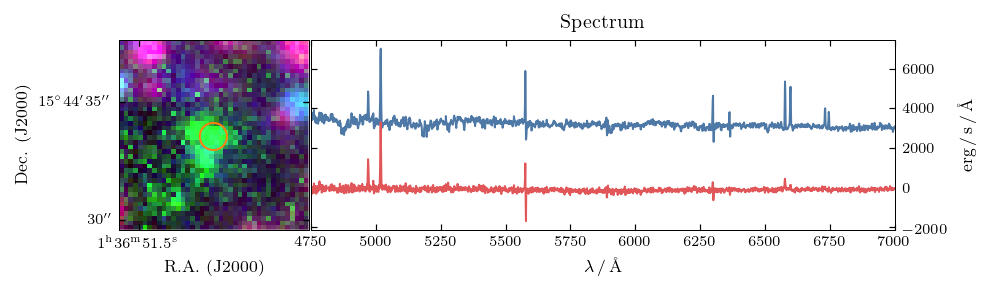

In [12]:
pn = pn_candidates[0]
print(f'ID: {pn["ID"]}, mOIII={pn["mOIII"]}')
filename = basedir / 'reports' / 'overluminous' / f'{galaxy.name}_{pn["ID"]}.pdf'
spectra,wavelength = spectrum_and_rgb(pn['SkyCoord'],galaxy,data_cube,galaxy.wcs,aperture_size=1.5,filename=filename)


In [23]:
HST_cutout = Cutout2D(HST_whitelight,pn_candidates['SkyCoord'][0],8*u.arcsec,wcs=WCS(HST_whitelight_header))

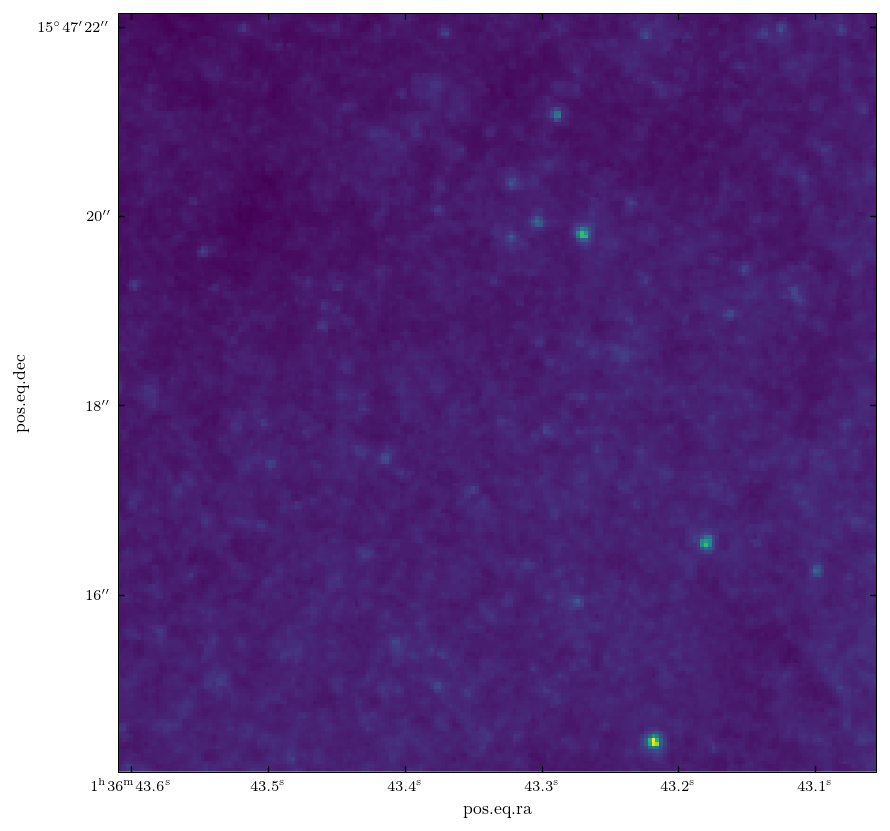

In [24]:
fig = plt.figure(figsize=(two_column,two_column))
ax  = fig.add_subplot(projection=HST_cutout.wcs)

norm = simple_norm(HST_cutout.data)
ax.imshow(HST_cutout.data,norm=norm)

plt.show()

In [ ]:
spectra,wavelength = cutout_spectrum(pn_candidates['SkyCoord'][0],galaxy.OIII5006,data_cube,galaxy.wcs)

In [ ]:
spectra,wavelength = cutout_spectrum(pn_candidates['SkyCoord'][1],galaxy.OIII5006,data_cube,galaxy.wcs)

In [ ]:
# NGC1566
spectra,wavelength = cutout_spectrum(pn_candidates['SkyCoord'][0],galaxy.OIII5006,data_cube,galaxy.wcs)

(0.9374999999999999, 2.1746645029092277e-13)


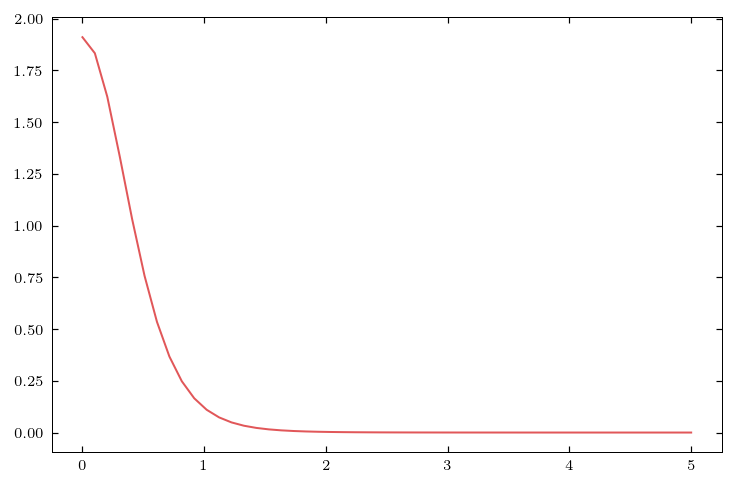

In [43]:
def Moffat(r,alpha,beta):
    
    return 2 * (beta-1)/(np.pi*alpha**2) * (1+(r/alpha)**2)**(-beta)

alpha, beta = 1,4

r = np.linspace(0,5)

plt.plot(r,Moffat(r,alpha,beta))

print(quad(Moffat,0,1e3,args=(alpha,beta)))

In [28]:
from scipy.integrate import quad

(3.141592642923177, 8.293165150388289e-10)